In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Kaustade nimed ja klasside määramine
class_names = ["COVID19", "NORMAL", "PNEUMONIA", "TURBERCULOSIS"]
image_data = []
labels = []
# Andmete laadimine
for idx, class_name in enumerate(class_names):
    folder_path = f"Chest X_Ray Dataset/{class_name}"
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(img)
        labels.append(idx)  # Määrake klassi indeks

In [3]:
# Muuda andmed numpy massiivideks
image_data = np.array(image_data)
labels = np.array(labels)
# Andmete jaotamine treening-, valideerimis- ja testikomplektideks
X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42
)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
datagen.fit(X_train)

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Kasuta eelnevalt treenitud ResNet50 mudelit
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Ära treeni eelnevalt treenitud kihti

In [6]:
# Täiendame mudelit
model = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint  # LISATUD

checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}.keras"),
    save_weights_only=False,  # Salvesta kogu mudel
    save_best_only=True,  # Salvesta iga epohhi lõpus
    verbose=1,
)

In [8]:
# Treenime mudelit
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=2,  # mingi 10 minimum äkki sobiks
    callbacks=[checkpoint_callback],  # lisatud........
)

/opt/homebrew/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
 26/179 ━━━━━━━━━━━━━━━━━━━━ 1:52 732ms/step - accuracy: 0.6170 - loss: 1.0471

KeyboardInterrupt: 

In [9]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 761ms/step
[[  0   0 133   0]
 [  0   0 317   0]
 [  0   0 835   0]
 [  0   0 142   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.00      0.00      0.00       317
           2       0.59      1.00      0.74       835
           3       0.00      0.00      0.00       142

    accuracy                           0.59      1427
   macro avg       0.15      0.25      0.18      1427
weighted avg       0.34      0.59      0.43      1427



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
results = model.evaluate(X_test, y_test, batch_size=8)
print(model.metrics_names)  # Kuvab saadavalolevate mõõdikute nimed
print(results)

179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.5757 - loss: 1.1288
['loss', 'compile_metrics']
[1.1200802326202393, 0.5851436853408813]


In [12]:
import matplotlib.pyplot as plt

print(history.history.keys())  #
plt.plot(history.history["accuracy"], label="Treening täpsus")
plt.plot(history.history["val_accuracy"], label="Valideerimise täpsus")
plt.xlabel("Epohhid")
plt.ylabel("Täpsus")
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
print(f"accuracy: {history.history['val_accuracy']}")
print(f"accuracy: {history.history['accuracy']}")

accuracy: [0.5851436853408813, 0.5879467129707336]
accuracy: [0.5964943170547485, 0.6054338216781616]


<h1>uute piltide testimine<h1>


<font color="red">Ma tegin kausta "uued" ja panin sinna pildid ja siis üritab
neid arvata</font>


In [13]:
import tensorflow as tf

new_images_path = "uued"  # Kaust, kus on uued pildid

# Kategooriate nimed
categories = ["COVID19", "PNEUMONIA", "TUBERCOLOSIS", "NORMAL"]

# Laadime uued pildid
new_images = []
for img_name in os.listdir(new_images_path):
    img_path = os.path.join(new_images_path, img_name)

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    new_images.append(img_array)

# Muudame uued pildid numpy massiiviks
new_images = np.array(new_images)

# Normaliseerime pildid, et need oleksid vahemikus [0, 1]
new_images = new_images / 255.0

# Ennustamine uute piltide kohta
predictions = model.predict(new_images)

# Kuvame tulemused
for i, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)  # Kõrgeima tõenäosusega klass
    print(
        f"Pilt {i+1}: Ennustus: {categories[predicted_class]}, Tõenäosus: {prediction[predicted_class]:.2f}"
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Pilt 1: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.50
Pilt 2: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.49
Pilt 3: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.51
Pilt 4: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.51


In [14]:
from tensorflow.keras.utils import image_dataset_from_directory

# Lae testandmestik
test_dataset = image_dataset_from_directory(
    "Chest X_Ray Dataset",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
)

# Hindamine mudeliga
loss, accuracy = model.evaluate(test_dataset)
print(f"Testandmete täpsus: {accuracy:.2f}")

Found 7132 files belonging to 4 classes.
 59/223 ━━━━━━━━━━━━━━━━━━━━ 2:16 830ms/step - accuracy: 0.2587 - loss: 3.7110

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


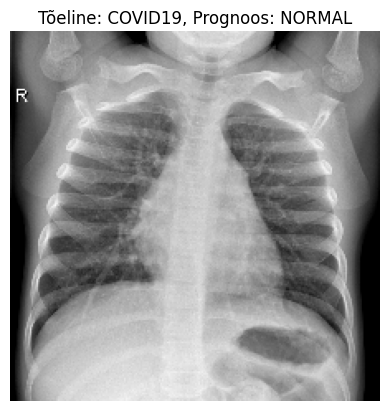

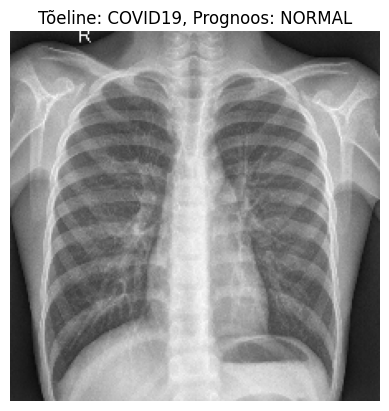

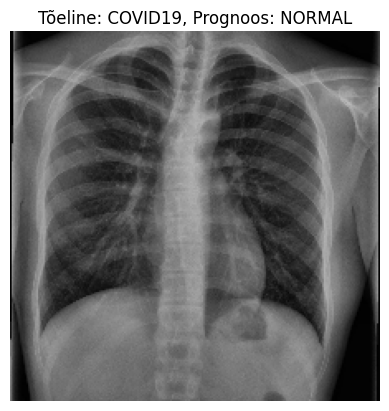

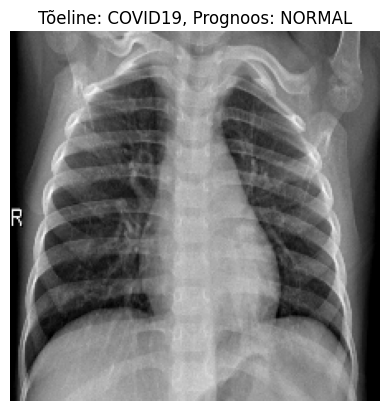

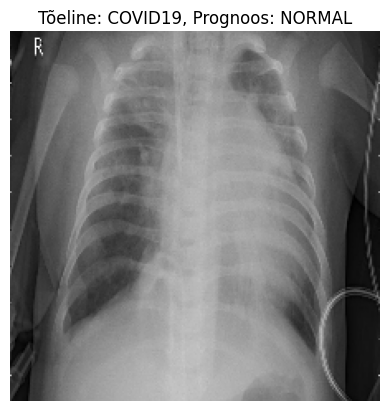

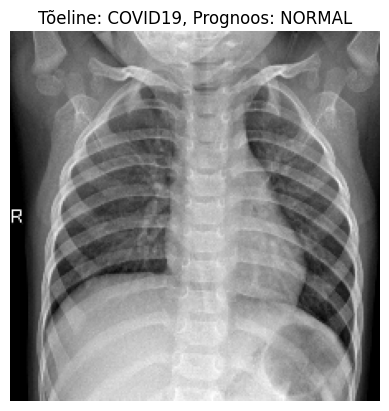

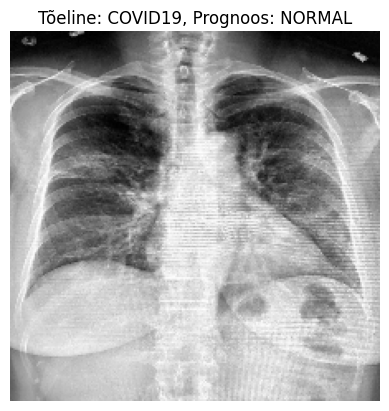

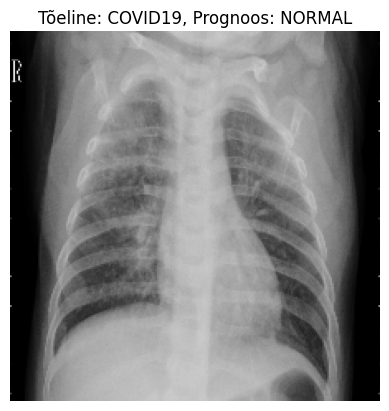

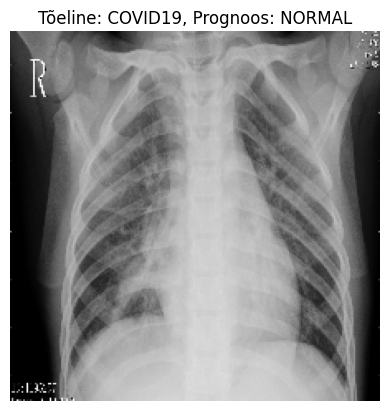

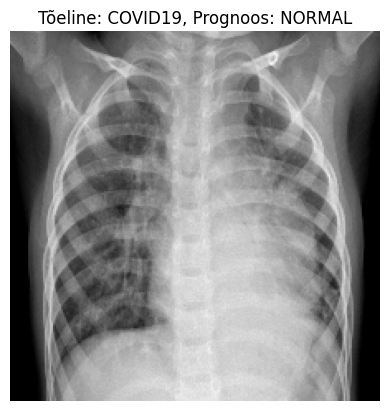

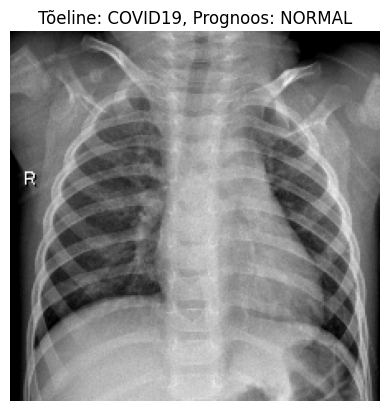

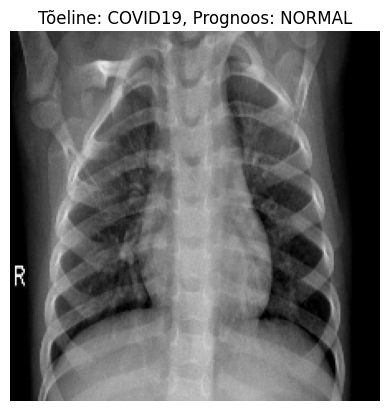

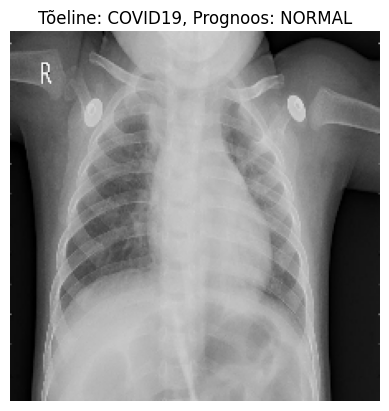

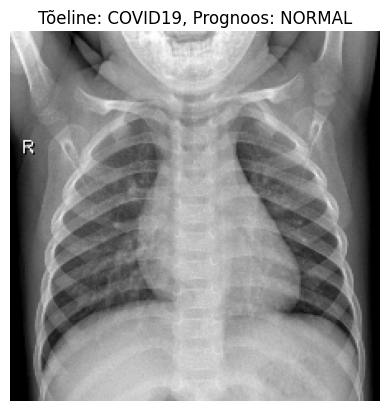

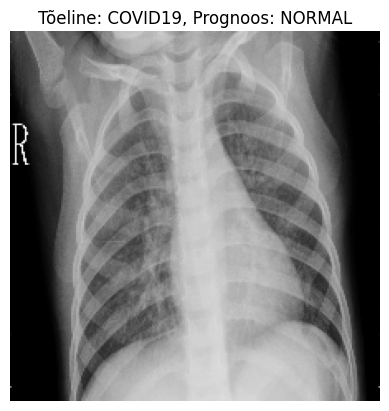

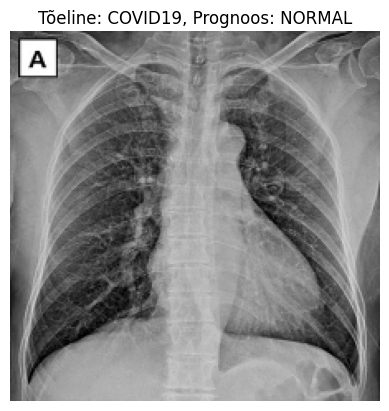

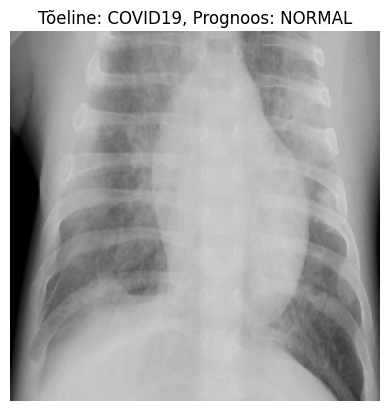

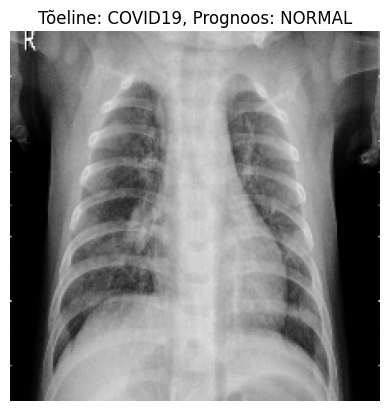

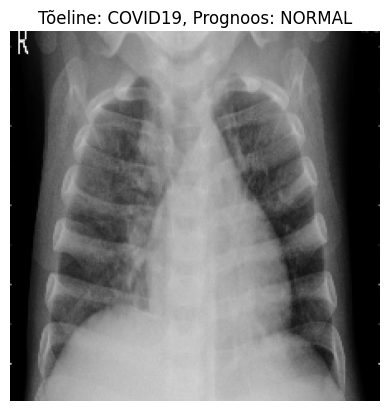

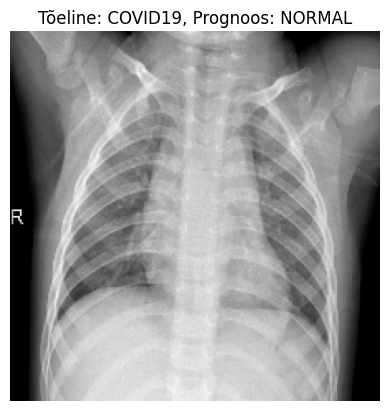

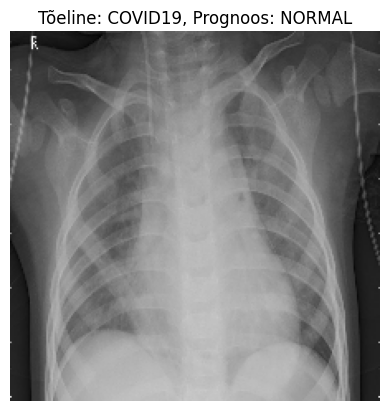

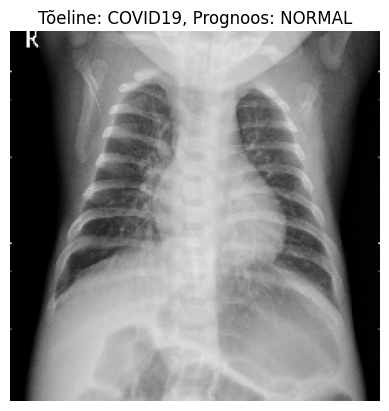

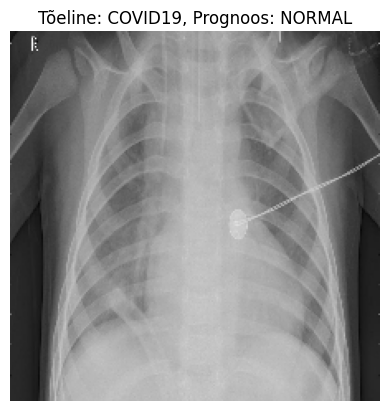

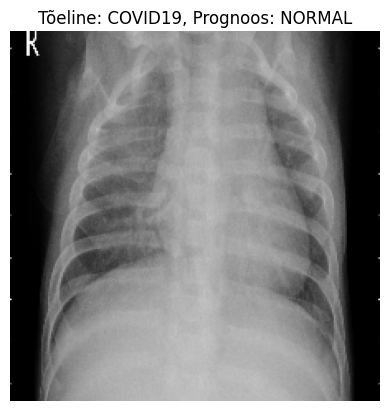

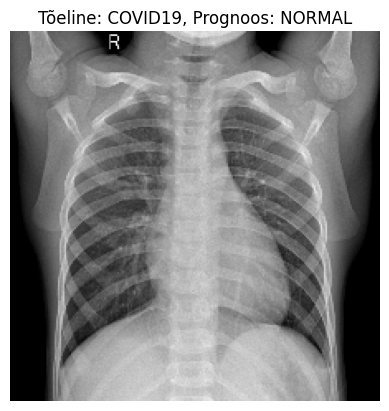

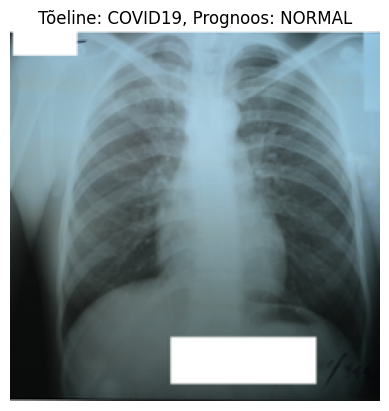

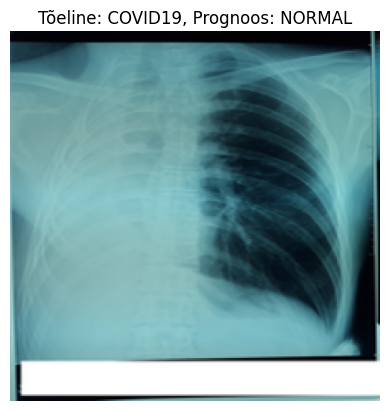

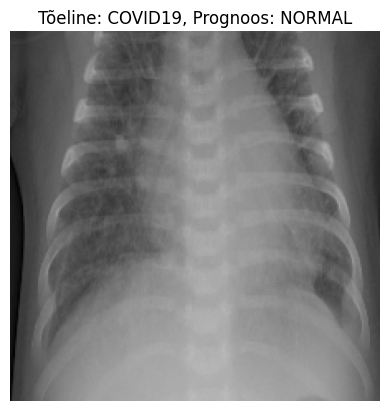

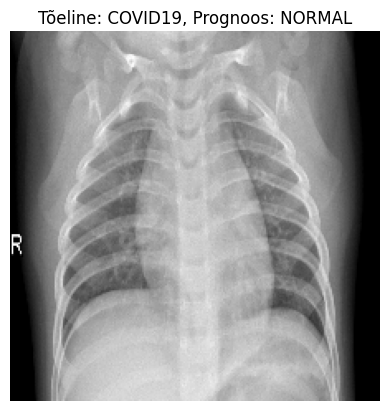

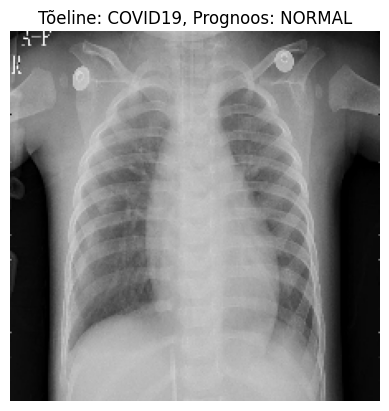

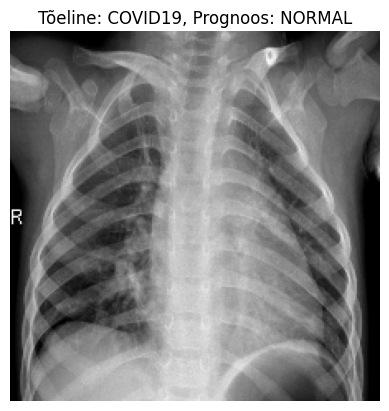

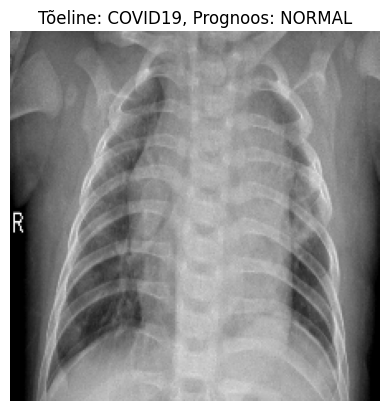

In [ ]:
import matplotlib.pyplot as plt

for images, labels in test_dataset.take(1):  # Võta esimene partii testandmeid
    predictions = model.predict(images)
    for i in range(len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = categories[np.argmax(predictions[i])]
        true_class = categories[np.argmax(labels[i].numpy())]
        plt.title(f"Tõeline: {true_class}, Prognoos: {predicted_class}")
        plt.axis("off")
        plt.show()

In [ ]:
def load_model_from_epoch(epoch_num):  # lisatud
    model_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch_num:02d}.keras")
    if os.path.exists(model_path):
        print(f"Laen mudelit failist: {model_path}")
        return tf.keras.models.load_model(model_path)
    else:
        raise FileNotFoundError(f"Faili {model_path} ei leitud.")


loaded_model = load_model_from_epoch(2)
# Kuvage mudeli struktuur
loaded_model.summary()
"""
# Prognoosige testandmetega
for images, labels in test_dataset.take(1):
    predictions = loaded_model.predict(images)
    print(predictions)
"""

Laen mudelit failist: model_checkpoints/model_epoch_02.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,302 (90.07 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,394 (64.04 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[1.37304742e-11 8.52141093e-05 7.44423900e-09 9.99914825e-01]
 [4.58829003e-10 9.73584596e-04 3.38557200e-08 9.99026418e-01]
 [1.64382841e-12 4.01332109e-05 4.73853942e-11 9.99959886e-01]
 [1.05815426e-11 1.74046891e-05 3.54912384e-11 9.99982655e-01]
 [4.21983670e-10 4.18287149e-04 5.18101722e-08 9.99581695e-01]
 [1.33193900e-10 5.15316333e-06 3.34918560e-09 9.99994874e-01]
 [3.28995470e-10 1.49896822e-03 3.71596176e-09 9.98501003e-01]
 [1.07643698e-08 1.22403391e-04 8.56110375e-07 9.99876738e-01]
 [2.66076439e-10 8.80906999e-04 6.88446491e-08 9.99118984e-01]
 [1.91263186e-11 4.52319764e-05 1.69916980e-09 9.99954879e-01]
 [1.28108192e-11 3.11997719e-05 4.89232432e-10 9.99968827e-01]
 [8.13990475e-09 1.35284360e-03 1.64974701e-08 9.98647094e-01]
 [1.56438001e-10 1.00989055e-04 7.40029282e-09 9.99899089e-01]
 [8.76157896e-11 4.51665459e-04 2.63190025e-09 9.99548256e-01]
 [3.46099011e-10 1.58474606e-04 2.91220381e-08 9.99841511e-01]
 [1.12038798e-11 2.

2024-12-06 19:18:13.078402: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Laen mudelit failist: model_checkpoints/model_epoch_01.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 803ms/step
[[  0   0 133   0]
 [  0   0 317   0]
 [  0   0 835   0]
 [  0   1 141   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.00      0.00      0.00       317
           2       0.59      1.00      0.74       835
           3       0.00      0.00      0.00       142

    accuracy                           0.59      1427
   macro avg       0.15      0.25      0.18      1427
weighted avg       0.34      0.59      0.43      1427



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


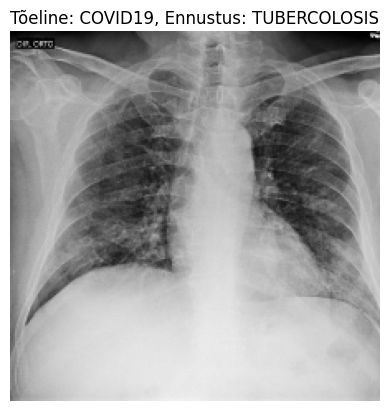

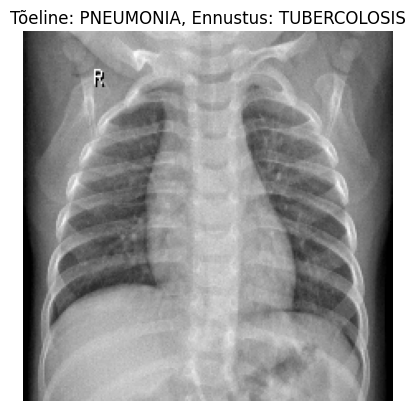

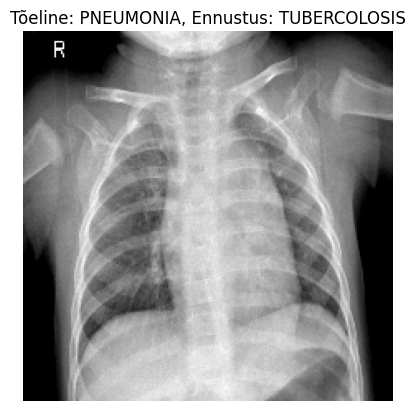

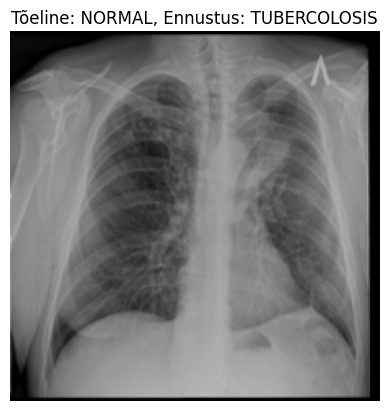

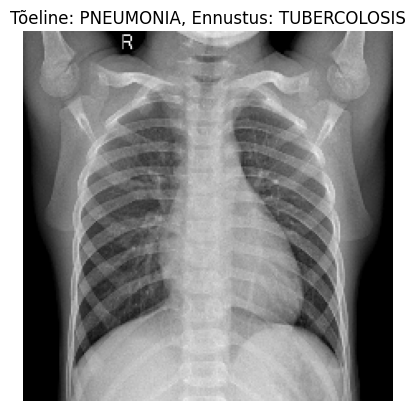

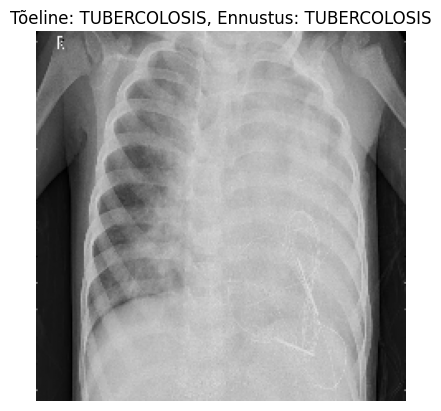

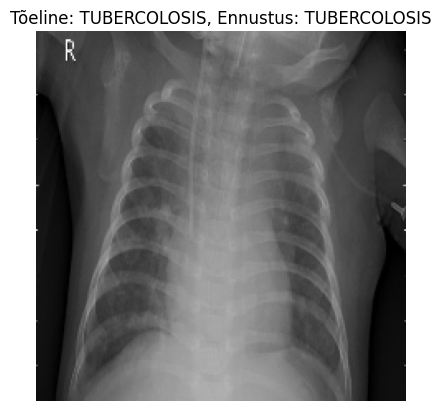

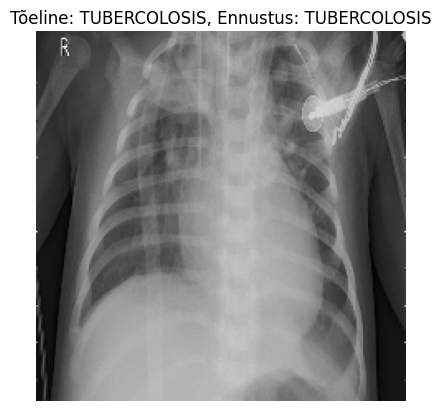

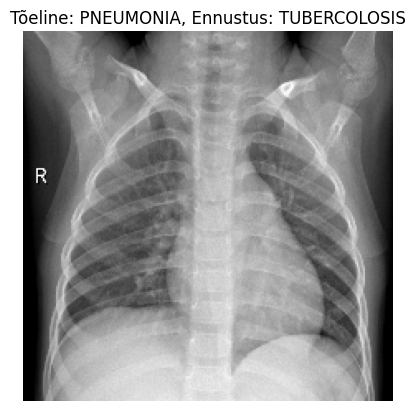

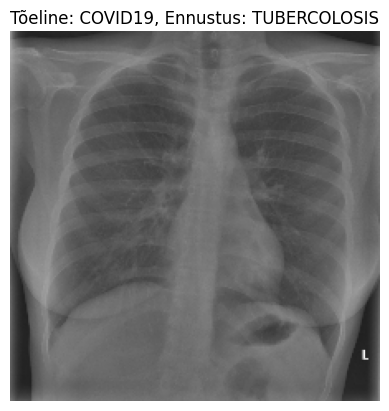

In [19]:
# vali mis mudeliga tahad testida
loaded_model = load_model_from_epoch(1)

# Ennustamine testandmetega
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Kuvame tulemused
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

# Kuvame mõned ennustused koos piltidega
import matplotlib.pyplot as plt

for i in range(10):  # Kuvame esimesed 10 pilti ja nende ennustused
    plt.imshow(X_test[i])
    true_class = categories[y_test[i]]
    predicted_class = categories[y_pred_classes[i]]
    plt.title(f"Tõeline: {true_class}, Ennustus: {predicted_class}")
    plt.axis("off")
    plt.show()